In [ ]:
from google.colab import files
files.upload()


{}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission


kaggle.json


I completed this project on Google Colab. For this to access Google colab I write some code in upper two cells. If you run this code on your local machine you don't need upper cells. 

### Loading Necessary Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

import warnings; warnings.simplefilter('ignore')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Reading Dataset

In [2]:
# # I am not going to use 4 dataset instead will use only one dataset becase of huge number of rows
df1 = pd.read_csv('/content/drive/My Drive/Netflix Movie Recommendation/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])


### Dataset Initializing

In [3]:
# keeping df1 in new variable
data_frame = df1  

In [4]:
# printing head of the dataset
data_frame.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [5]:
# shape of the dataset
data_frame.shape

(24058263, 2)

In [6]:
# changing data type of Rating column
data_frame['Rating'] = data_frame['Rating'].astype(float)

# printing some data of df
print(data_frame.iloc[::3000000, :])

          Cust_Id  Rating
0              1:     NaN
3000000   2068490     4.0
6000000   1091776     4.0
9000000    593351     4.0
12000000   700005     2.0
15000000  1921803     2.0
18000000   460528     3.0
21000000  1336822     3.0
24000000   517002     4.0


In [7]:
# using array for index because otherwise, kernel will stop.
data_frame.index = np.arange(0,len(data_frame))

print('Shape of the dataset is :', data_frame.shape)
print(data_frame.iloc[::3000000, :])

Shape of the dataset is : (24058263, 2)
          Cust_Id  Rating
0              1:     NaN
3000000   2068490     4.0
6000000   1091776     4.0
9000000    593351     4.0
12000000   700005     2.0
15000000  1921803     2.0
18000000   460528     3.0
21000000  1336822     3.0
24000000   517002     4.0


## Data Visualization

In [8]:
p = data_frame.groupby('Rating')['Rating'].agg(['count'])
p

,count
Rating,
1.0,1118186
2.0,2439073
3.0,6904181
4.0,8085741
5.0,5506583


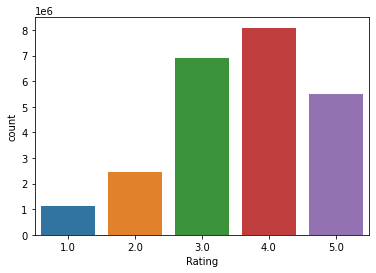

In [9]:
sns.barplot(x=p.index, y=p['count'])

Based on rating dataset is unlabel. where Rating 3,4 and 5 are near. Rating 1 and 2 are near. 

### Dataset Cleaning

In [10]:
# seperating only nun rows
df_nan = pd.DataFrame(pd.isnull(data_frame.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()
df_nan.head()

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True


In [11]:
movie_np = []
movie_id = 1

# taking index of the movie using numpy array. Because here need huge number, for this kernel will restart.
for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

last_record = np.full((1,len(data_frame) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))


Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [12]:
# remove null rows
data_frame = data_frame[pd.notnull(data_frame['Rating'])]

# creating a new columns
data_frame['Movie_Id'] = movie_np.astype(int)
data_frame['Cust_Id'] = data_frame['Cust_Id'].astype(int)

# printing some data from data_frame
print(data_frame.iloc[::3000000, :])


          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
3000564   2288257     3.0       564
6001180   1760220     3.0      1180
9001798   1973661     5.0      1798
12002340   741670     3.0      2340
15002876   886608     2.0      2876
18003427   562860     1.0      3427
21003938  1733776     5.0      3938
24004488   163209     3.0      4488


### Reduce Some rows

This dataset have more than 22 million rows. Working with lots of data need huge time and good confugured PC. For this I am going to reduce some rows, which are less important. 

In [13]:
# grouping Rating based on Cust_Id
data_frame_customer = data_frame.groupby('Cust_Id')['Rating'].agg(['count', 'mean'])
data_frame_customer.index = data_frame_customer.index.map(int)
movie_benchmark_customer = round(data_frame_customer['count'].quantile(0.8), 0)
drop_movie_list_customer = data_frame_customer[data_frame_customer['count'] < movie_benchmark_customer].index
print('Limit of movie benchmark is :{} Total number of dropping rows {} '.format(movie_benchmark_customer, len(drop_movie_list_customer)))

# grouping Rating based on Movie_Id
data_frame_movie = data_frame.groupby('Movie_Id')['Rating'].agg(['count', 'mean'])
data_frame_movie.index = data_frame_movie.index.map(int)
movie_benchmark_movie = round(data_frame_movie['count'].quantile(0.8), 0)
drop_movie_list_movie = data_frame_movie[data_frame_movie['count'] < movie_benchmark_movie].index
print('Limit of movie_benchmark_movie is :{} Total number of dropping rows {} '.format(movie_benchmark_movie, len(drop_movie_list_movie)))



Limit of movie benchmark is :79.0 Total number of dropping rows 375433 
Limit of movie_benchmark_movie is :3884.0 Total number of dropping rows 3599 


In [59]:
# original shape
print('Original shape of the dataset is : ', data_frame.shape)

# dropping selected rows
data_frame = data_frame[~data_frame['Cust_Id'].isin(drop_movie_list_customer)]
data_frame = data_frame[~data_frame['Movie_Id'].isin(drop_movie_list_movie)]

# showing some data
data_frame.head()


Original shape of the dataset is :  (13528427, 3)


,Cust_Id,Rating,Movie_Id
5109,785314,1.0,8
5110,243963,3.0,8
5112,1447783,4.0,8
5116,1912665,1.0,8
5119,1744889,1.0,8


### Dataset Mapping

In [15]:
movie_title = pd.read_csv("/content/drive/My Drive/Netflix Movie Recommendation/datasets_1636_792972_movie_titles.csv", encoding = "ISO-8859-1", header=None, names=['Movie_Id', 'Year', 'Name'])
movie_title.head()

,Movie_Id,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [16]:
movie_title.shape

(17770, 3)

In [ ]:
# using Movie_Id column as index
movie_title.set_index('Movie_Id', inplace=True)
movie_title.head()

### Recommendation technique

I am going to use three recommendation technique:

    1. Simple Recommendation
    2. Collaborative Recommendation
    3. Pearsons'R correlations

### Simple Recommendation

In [63]:
data_frame.head()

,Cust_Id,Rating,Movie_Id
5109,785314,1.0,8
5110,243963,3.0,8
5112,1447783,4.0,8
5116,1912665,1.0,8
5119,1744889,1.0,8


In [64]:
print('Shape of the data_frame is :', data_frame.shape)

Shape of the data_frame is : (13528427, 3)


In [67]:
def simple_recommendation(rating, movie_id):
  data_frame_select = data_frame[(data_frame['Rating']==rating) & (data_frame['Movie_Id']==movie_id)]
  return (data_frame_select.head(20))


In [68]:
simple_recommendation(5, 8)

,Cust_Id,Rating,Movie_Id
5131,56069,5.0,8
5168,802657,5.0,8
5172,1829027,5.0,8
5216,1174811,5.0,8
5218,724373,5.0,8
5225,2551418,5.0,8
5237,1666394,5.0,8
5260,1646405,5.0,8
5296,1244213,5.0,8
5321,1649154,5.0,8


#### Collaborative Recommendation

In [18]:
reader = Reader()

# getting small part of the big dataset
slice_data = Dataset.load_from_df(data_frame[['Cust_Id','Movie_Id','Rating']][:500000], reader)


In [19]:
# Use the famous SVD(singular value decomposition) algorithm
algo = SVD()

# Run 5-fold cross-validation and then print results
cross_validate(algo, slice_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9636  0.9584  0.9634  0.9622  0.9613  0.9618  0.0019  
MAE (testset)     0.7580  0.7554  0.7591  0.7571  0.7580  0.7575  0.0012  
Fit time          22.01   22.25   22.11   22.18   22.45   22.20   0.15    
Test time         0.83    0.81    0.84    0.82    0.84    0.83    0.01    


{'fit_time': (22.00942635536194,
  22.249385356903076,
  22.10576367378235,
  22.184722661972046,
  22.4454665184021),
 'test_mae': array([0.75796682, 0.75539326, 0.75905556, 0.75705648, 0.75796938]),
 'test_rmse': array([0.96364034, 0.95841992, 0.96344837, 0.96215419, 0.96133144]),
 'test_time': (0.8319392204284668,
  0.8131742477416992,
  0.837468147277832,
  0.8236374855041504,
  0.8368277549743652)}

In [24]:
def predict_movie(movie_id):
  movie_title_filter = movie_title.copy()
  movie_title_filter = movie_title_filter.reset_index()
  movie_title_filter = movie_title_filter[~movie_title_filter['Movie_Id'].isin(drop_movie_list_movie)]

  # getting full dataset
  #data_set = Dataset.load_from_df(data_frame[['Cust_Id','Movie_Id','Rating']], reader)

  train_set = slice_data.build_full_trainset()
  algo.fit(train_set)

  movie_title_filter['estimated_score'] = movie_title_filter['Movie_Id'].apply(lambda x: algo.predict(movie_id, x).est)
  #movie_title_filter = movie_title_filter.drop('Movie_Id', axis=1)
  movie_title_filter = movie_title_filter.sort_values('estimated_score', ascending=False)
  return movie_title_filter.head(20)




In [25]:
# 20 predicted movie who watch 785314 movie. 
predict_movie(785314)

,Movie_Id,Year,Name,estimated_score
32,33,2000.0,Aqua Teen Hunger Force: Vol. 1,3.767588
96,97,2002.0,Mostly Martha,3.514531
198,199,1978.0,The Deer Hunter,3.428755
164,165,1982.0,Richard Pryor: Live on the Sunset Strip,3.411810
174,175,1992.0,Reservoir Dogs,3.373749
155,156,1992.0,Husbands and Wives,3.312110
142,143,1997.0,The Game,3.160774
166,167,2004.0,The Chorus,3.079652
151,152,1995.0,A Little Princess,3.070122
170,171,1957.0,Funny Face,3.041785


In [26]:
# 20 predicted movie who watch 13051 movie. 
predict_movie(13051)

,Movie_Id,Year,Name,estimated_score
32,33,2000.0,Aqua Teen Hunger Force: Vol. 1,4.280597
174,175,1992.0,Reservoir Dogs,4.190427
190,191,2003.0,X2: X-Men United,4.011553
166,167,2004.0,The Chorus,4.006044
164,165,1982.0,Richard Pryor: Live on the Sunset Strip,4.005953
137,138,1995.0,Star Trek: Voyager: Season 1,3.939132
198,199,1978.0,The Deer Hunter,3.910769
142,143,1997.0,The Game,3.893770
27,28,2002.0,Lilo and Stitch,3.821548
96,97,2002.0,Mostly Martha,3.820011


#### Pearsons'R correlations

In [53]:
# small part of the dataset
dataset_part = data_frame.iloc[:500000, :]

# making pivot table
data_frame_pivot = pd.pivot_table(dataset_part, values='Rating', index='Cust_Id', columns='Movie_Id')
data_frame_pivot.head()


Movie_Id,8,17,18,26,28,30,33,44,46,52,58,77,78,83,97,108,111,118,138,143,148,152,156,165,166,167,171,175,187,189,191,197,199
Cust_Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,2.0,3.0,NaN
7,5.0,NaN,NaN,NaN,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN
134,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN


In [54]:
# shape of the pivot table
data_frame_pivot.shape

(94487, 33)

In [55]:
def pearsons_recommend(movie_name, min_count):
    i = int(movie_title.index[movie_title['Name'] == movie_name][0])
    target = data_frame_pivot[i]
    similar_to_target = data_frame_pivot.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(movie_title).join(data_frame_movie)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:20].to_string(index=False))


In [56]:
# 20 correlated movie.
pearsons_recommend("What the #$*! Do We Know!?", 0)

 PearsonR                                     Name   count      mean
 1.000000               What the #$*! Do We Know!?   14910  3.189805
 0.283274                               The Chorus    9151  4.092230
 0.276668             Star Trek: Voyager: Season 1    6007  3.942234
 0.261031                           Spitfire Grill    8501  3.684037
 0.254211  Richard Pryor: Live on the Sunset Strip    4588  3.916957
 0.207582                  The Weather Underground    5147  3.757140
 0.196853                         Immortal Beloved   10722  3.784369
 0.192240                        A Little Princess    9162  3.934076
 0.185087                            Mostly Martha   11508  3.871828
 0.182327                              Dragonheart   17405  3.612008
 0.151992           Aqua Teen Hunger Force: Vol. 1    6890  4.168650
 0.144331                         Death to Smoochy   20049  3.012170
 0.144275                                  Spartan   19018  3.167315
 0.144248                         

In [57]:
# 20 correlated movie.
pearsons_recommend("Spitfire Grill", 0)

 PearsonR                                     Name   count      mean
 1.000000                           Spitfire Grill    8501  3.684037
 0.403315                               The Chorus    9151  4.092230
 0.357938             Star Trek: Voyager: Season 1    6007  3.942234
 0.312721                            Mostly Martha   11508  3.871828
 0.308514                                 Silkwood   18724  3.729331
 0.306246                              Dragonheart   17405  3.612008
 0.303453                          Never Die Alone    5861  2.793721
 0.294870                                     Fame    9435  3.556333
 0.290659                        A Little Princess    9162  3.934076
 0.288359                               Funny Face    6190  3.742488
 0.267499                         Immortal Beloved   10722  3.784369
 0.261825                                7 Seconds    7108  2.903208
 0.261031               What the #$*! Do We Know!?   14910  3.189805
 0.255457                         